[7, 18, 19, 1, 4, 8, 11, 24, 26]


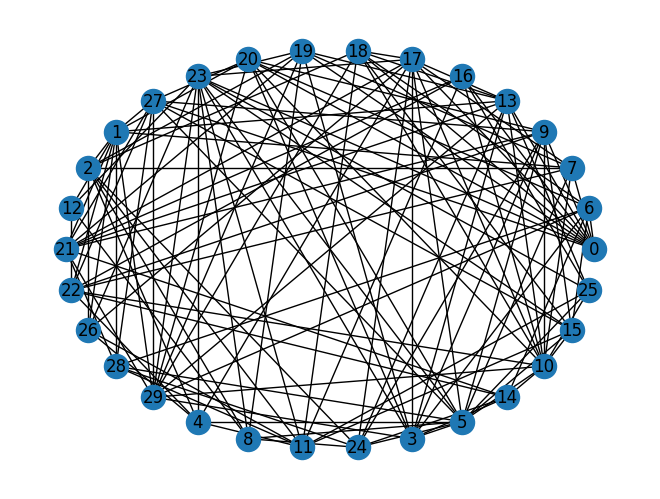

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import baseGrafo

G = nx.read_edgelist("grafoBase2.csv", delimiter=",")
G = nx.relabel_nodes(G, lambda x: int(x))
print(list(G.neighbors(2)))

nx.draw_circular(G, with_labels=True)

Número mínimo de cores: 1
Coloração final dos vértices:
Vértice 0: Cor 0
Vértice 1: Cor 1
Vértice 2: Cor 2
Vértice 3: Cor 0
Vértice 4: Cor 0


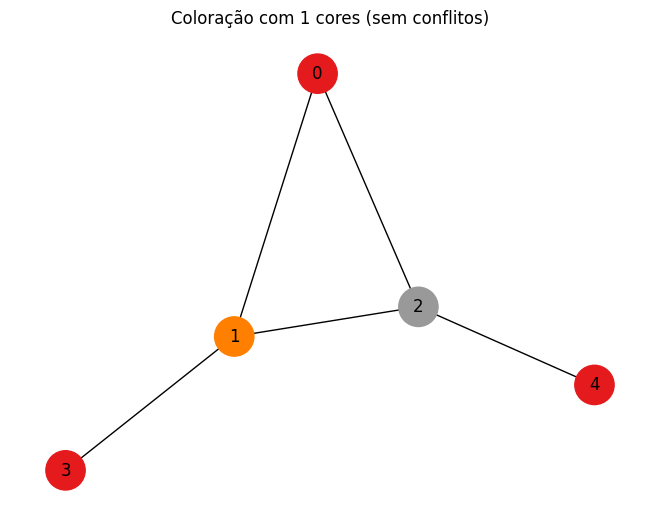

In [2]:


# Gerador de grafo exemplo
def gerar_grafo_exemplo():
    G = nx.Graph()
    arestas = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4)]
    G.add_edges_from(arestas)
    return G

# Cálculo de conflitos
def calcular_conflitos(G: nx.Graph, coloracao: Dict[int, int]) -> int:
    conflitos = 0
    for u, v in G.edges():
        if coloracao[u] == coloracao[v]:
            conflitos += 1
    return conflitos

# Geração da vizinhança (troca a cor de 1 vértice aleatoriamente)
def gerar_vizinhos(G: nx.Graph, coloracao: Dict[int, int], n_cores: int) -> List[Tuple[Dict[int, int], Tuple[int, int]]]:
    vizinhos = []
    for v in G.nodes():
        cor_atual = coloracao[v]
        for nova_cor in range(n_cores):
            if nova_cor != cor_atual:
                nova_coloracao = coloracao.copy()
                nova_coloracao[v] = nova_cor
                movimento = (v, nova_cor)
                vizinhos.append((nova_coloracao, movimento))
    return vizinhos

# Algoritmo de Busca Tabu
def busca_tabu_coloracao(G: nx.Graph, max_iter: int, tabu_tamanho: int, n_cores: int):
    atual, n_cores= baseGrafo.heuristicaGulosa(G)
    custo_atual = calcular_conflitos(G, atual)
    melhor = atual.copy()
    melhor_custo = custo_atual
    lista_tabu = []

    for _ in range(max_iter):
        vizinhos = gerar_vizinhos(G, atual, n_cores)
        melhor_vizinho = None
        menor_custo = float('inf')
        movimento_escolhido = None

        for vizinho, movimento in vizinhos:
            custo = calcular_conflitos(G, vizinho)
            if (movimento not in lista_tabu) or (custo < melhor_custo):  # aspiração
                if custo < menor_custo:
                    melhor_vizinho = vizinho
                    menor_custo = custo
                    movimento_escolhido = movimento

        if melhor_vizinho is None:
            break

        atual = melhor_vizinho
        custo_atual = menor_custo
        lista_tabu.append(movimento_escolhido)

        if len(lista_tabu) > tabu_tamanho:
            lista_tabu.pop(0)

        if custo_atual < melhor_custo:
            melhor = atual.copy()
            melhor_custo = custo_atual

        if melhor_custo == 0:
            break

    return melhor, melhor_custo

# Número cromático estimado
def encontrar_numero_minimo_de_cores(G: nx.Graph, max_iter: int, tabu_tamanho: int, limite_superior: int = None):
    if limite_superior is None:
        limite_superior = G.number_of_nodes()

    for n_cores in range(1, limite_superior + 1):
        coloracao, conflitos = busca_tabu_coloracao(G, max_iter=max_iter, tabu_tamanho=tabu_tamanho, n_cores=n_cores)
        if conflitos == 0:
            return n_cores, coloracao

    return None, None  # Não encontrou nenhuma coloração válida

def executar_completo():
    G = gerar_grafo_exemplo()
    menor_n_cores, melhor_coloracao = encontrar_numero_minimo_de_cores(G, max_iter=100, tabu_tamanho=5)

    print("Número mínimo de cores:", menor_n_cores)
    print("Coloração final dos vértices:")
    for vertice, cor in melhor_coloracao.items():
        print(f"Vértice {vertice}: Cor {cor}")

    # Visualização
    pos = nx.spring_layout(G, seed=42)
    cores = [melhor_coloracao[v] for v in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=cores, cmap=plt.cm.Set1, node_size=800)
    plt.title(f'Coloração com {menor_n_cores} cores (sem conflitos)')
    plt.show()

# Executar tudo
executar_completo()